# Homework 1

**Course**: FFR120 - Simulation of Complex Systems

**Author**: Artur Gasparyan

**Assignment**: Homework 1 - Option 4

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## Exercise 4.1 

In [10]:
def create_parent_generation(n_cells, rule_nr, rng):
    if rule_nr in (90, 30):
        parent_generation = np.zeros((n_cells,))
        parent_generation[n_cells//2] = 1
        
    else:
        parent_generation = rng.integers(0, 2, size=(n_cells,))
        
    return parent_generation


def create_grid_1d(rule_nr, n_cells, n_generations, rng):
    grid = np.zeros(shape=(n_generations, n_cells), dtype='uint8')
    grid[0, :] = create_parent_generation(n_cells, rule_nr, rng) 
    return grid


def decode_1d_rule(rule_number):
    binary_numbers = [
        (1, 1, 1), (1, 1, 0), (1, 0, 1), (1, 0, 0),
        (0, 1, 1), (0, 1, 0), (0, 0, 1), (0, 0, 0)
    ]

    rule = dict()
    num = rule_number
    for i in range(8):
        num, rem = divmod(num, 2)
        rule[binary_numbers[-i-1]] = rem

    return rule


def update_grid_1d(grid, n_cells, rules, rng):
    grid = np.roll(grid, 1, 0)
    for i in range(1, n_cells-1):
        pattern = grid[1, i-1:i+2]
        grid[0, i] = rules[tuple(pattern)]

    left_pattern = np.zeros(shape=(3,))
    left_pattern[0] = grid[1, -1]
    left_pattern[1:] = grid[1, :2]

    right_pattern = np.zeros(shape=(3,))
    right_pattern[-1] = grid[1, 0]
    right_pattern[:2] = grid[1, -2:]

    grid[0, 0] = rules[tuple(left_pattern)]
    grid[0, -1] = rules[tuple(right_pattern)]

    return grid


In [11]:
a = np.arange(10).reshape(5, 2)
np.roll(a, 1, 0)

array([[8, 9],
       [0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [12]:
decode_1d_rule(90)

{(0, 0, 0): 0,
 (0, 0, 1): 1,
 (0, 1, 0): 0,
 (0, 1, 1): 1,
 (1, 0, 0): 1,
 (1, 0, 1): 0,
 (1, 1, 0): 1,
 (1, 1, 1): 0}

In [13]:
def run_simulation_1d(n_cells, n_generations, rule_nr, rng):
    rules = decode_1d_rule(rule_number=rule_nr)
    grid = create_grid_1d(rule_nr, n_cells, n_generations, rng)
    history = []

    for gen in range(n_generations):
        grid = update_grid_1d(grid, n_cells, rules, rng)
        history.append(grid)

    return history


In [14]:
%matplotlib notebook

import matplotlib.animation as anim


def render_grid(time, history, img):
    img.set_array(history[time])
    return img,


def animate_simulation(history, framerate):
    fig = plt.figure()
    img = plt.imshow(history[0], interpolation='none', animated=True)
    animation = anim.FuncAnimation(fig=fig, func=render_grid, frames=len(history), interval=1000/framerate, fargs=(history,img), blit=True)    
    return animation


In [15]:
rng = np.random.default_rng()
n_cells = 80
n_generations = 80
framerate = 20
gif_writer = anim.PillowWriter(fps=framerate) 
save_file = False

<IPython.core.display.Javascript object>


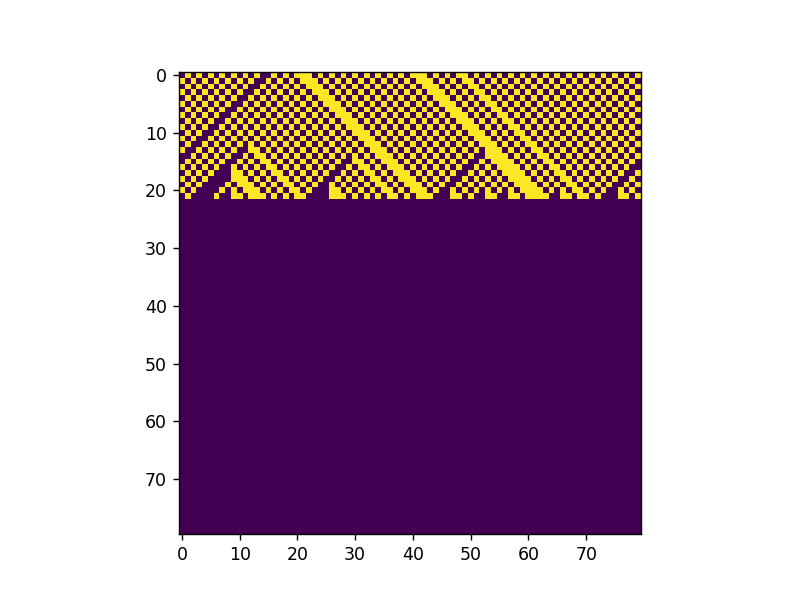

In [16]:
history_184 = run_simulation_1d(n_cells, n_generations, 184, rng)
animation_184 = animate_simulation(history_184, framerate)
if save_file:
    animation_184.save('./gifs/1d-evolution-184.gif', writer=gif_writer)

<IPython.core.display.Javascript object>


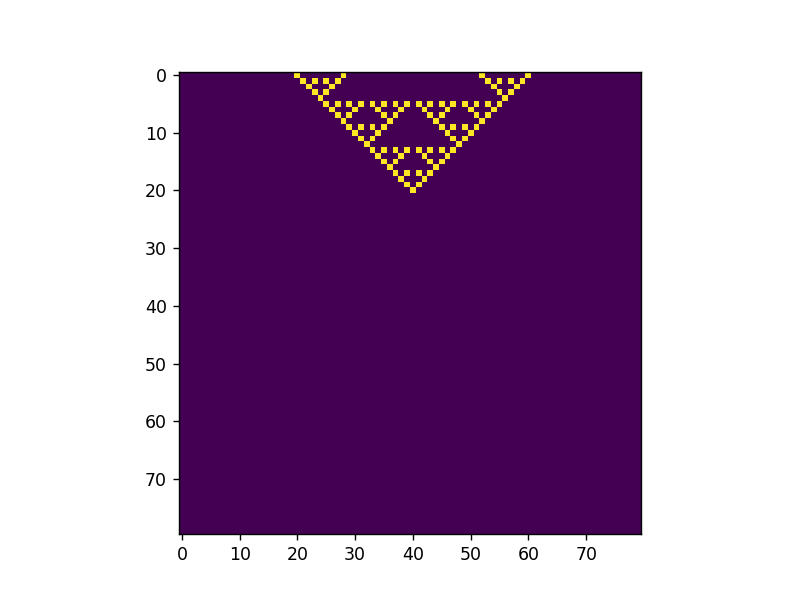

In [17]:
history_90 = run_simulation_1d(n_cells, n_generations, 90, rng)
animation_90 = animate_simulation(history_90, framerate)
if save_file:
    animation_90.save('./gifs/1d-evolution-90.gif', writer=gif_writer)

<IPython.core.display.Javascript object>


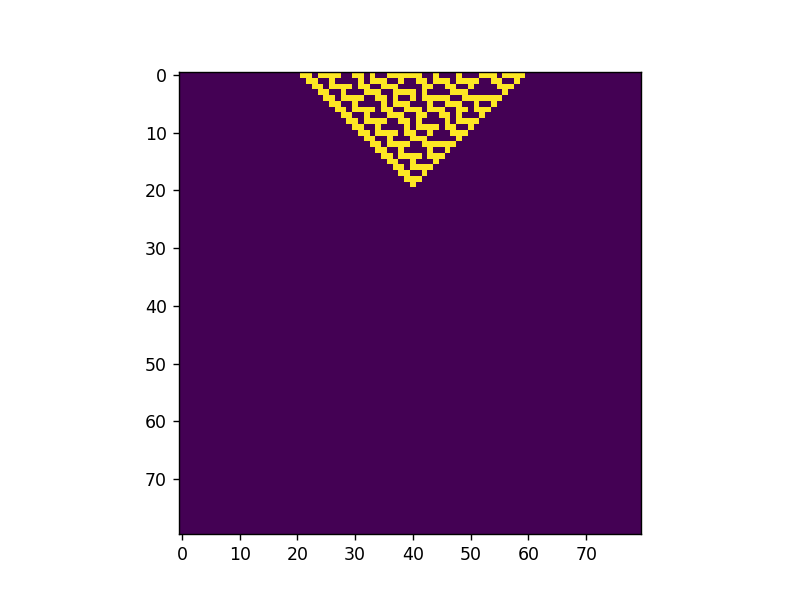

In [18]:
history_30 = run_simulation_1d(n_cells, n_generations, 30, rng)
animation_30 = animate_simulation(history_30, framerate)
if save_file:
    animation_30.save('./gifs/1d-evolution-30.gif', writer=gif_writer)

<IPython.core.display.Javascript object>


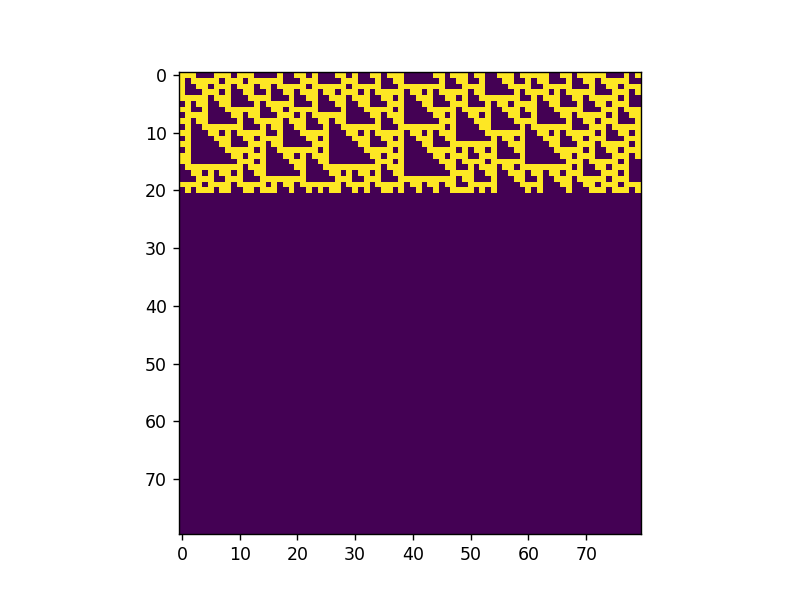

In [19]:
history_110 = run_simulation_1d(n_cells, n_generations, 110, rng)
animation_110 = animate_simulation(history_110, framerate)
if save_file:
    animation.save('./gifs/1d-evolution-110.gif', writer=gif_writer)

<IPython.core.display.Javascript object>


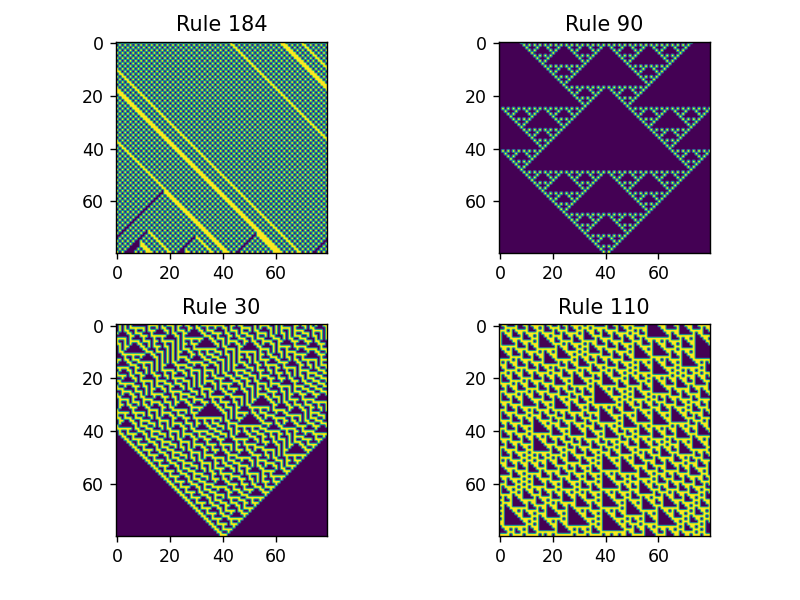

In [36]:
fig, axes = plt.subplots(2, 2)
histories = [history_184, history_90, history_30, history_110]
plt_names = ["Rule 184", "Rule 90", "Rule 30", "Rule 110"]
fig.tight_layout(pad=2)

for hist, ax, name in zip(histories, axes.flatten(), plt_names):
    ax.imshow(hist[-1])
    ax.set_title(name)
    

## Exercise 4.2

In [21]:
def create_grid(grid_size, rng):
    return rng.integers(0, 2, size=grid_size)


def get_nb_range(value, min, max, is_periodic_boundary):
    if value == min:
        if is_periodic_boundary:
            return max, min, min+1
        else:
            return min, min+1
        
    elif value == max:
        if is_periodic_boundary:
            return max-1, max, min
        else:
            return max-1, max
    
    else:
        return value-1, value, value+1
    

def enough_nbs_to_live(value, n_nbs):
    return n_nbs == 3 or (n_nbs == 2 and value)


In [22]:
def update_grid(grid, grid_size, is_periodic_boundary):
    new_grid = np.zeros(shape=grid_size, dtype='uint8')
    w, h = grid_size
    
    for y in range(h):
        for x in range(w):
            xs = get_nb_range(x, 0, w-1, is_periodic_boundary)
            ys = get_nb_range(y, 0, h-1, is_periodic_boundary)
            nbgrid = np.ix_(ys, xs)

            value = grid[y, x]
            nbhood = grid[nbgrid]
            n_nbs = np.sum(nbhood) - value

            if enough_nbs_to_live(value, n_nbs):
                new_grid[y, x] = 1

    return new_grid


In [23]:
def run_simulation(initial_grid, n_generations, is_periodic_boundary):
    history = []
    grid_size = initial_grid.shape
    grid = initial_grid
    
    for gen in range(1, n_generations):
        grid = update_grid(grid, grid_size, is_periodic_boundary)
        history.append(grid)
        
    return history

In [24]:
rng = np.random.default_rng()
grid_size = 40, 40
grid = create_grid()

TypeError: create_grid() missing 2 required positional arguments: 'grid_size' and 'rng'